# Cifar Library and Demo

[This is a library](https://pkg.go.dev/github.com/gomlx/gomlx/examples/cifar) to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

This notebook serves as documentation and example for the [github.com/gomlx/gomlx/examples/cifar](https://github.com/gomlx/gomlx/examples/cifar) library.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*go mod edit -replace github.com/gomlx/gomlx="${HOME}/Projects/gomlx"

## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [2]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/data"
)

var flagDataDir = flag.String("data", "~/work/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

func AssertDownloaded() {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        AssertNoError(os.MkdirAll(*flagDataDir, 0777))
    }

    AssertNoError(cifar.DownloadCifar10(*flagDataDir))
    AssertNoError(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [3]:
!ls -lh ~/work/cifar/

total 323M
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
-rw-r--r-- 1 janpf janpf 161M Mar 16 07:57 cifar-100-binary.tar.gz
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
-rw-r--r-- 1 janpf janpf 163M Mar 16 07:57 cifar-10-binary.tar.gz


### Sample some images

The `cifar.LoadCifar10` and `cifar.LoadCifar100` funcitons load the whole dataset into a `tensor.Tensor`. Here we sample and display a few of each, to check things are working.


Example 10707: deer (4),Example 23381: horse (7),Example 52904: horse (7),Example 2873: ship (8)
Example 32686: cat (3),Example 25511: frog (6),Example 34525: truck (9),Example 46185: deer (4)

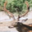
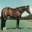
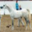
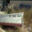
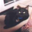
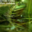
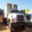
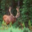

Example 35310: worm (99),Example 49198: bus (13),Example 762: cattle (19),Example 19115: leopard (42)
Example 688: couch (25),Example 29132: plain (60),Example 33101: telephone (86),Example 50430: spider (79)

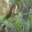
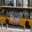
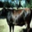
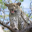
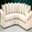
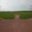
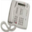
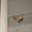

In [4]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/types/shapes"

    "github.com/janpfeifer/gonb/gonbui"
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook(rows, cols int) {
    dtype := shapes.Float32
    
    // Load data into tensors.
    images10, labels10, err := cifar.LoadCifar10(*flagDataDir, dtype)
    AssertNoError(err)
    images100, labels100, err := cifar.LoadCifar100(*flagDataDir, dtype)
    AssertNoError(err)
    
    sampleTable("Samples from Cifar-10", images10.Local(), labels10.Local(), cifar.C10Labels[:], rows, cols)
    sampleTable("Samples from Cifar-100", images100.Local(), labels100.Local(), cifar.C100FineLabels[:], rows, cols)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleTable(title string, images, labels *tensor.Local, labelsText []string, rows, cols int) {
    htmlRows := make([]string, 0, rows)
    for row := 0; row < rows; row++ {
        cells := make([]string, 0, cols)
        for col := 0; col < cols; col++ {
            cells = append(cells, sampleOneImage(images, labels, labelsText))
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", title, strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// sampleOneImage one image from tensor and returns an HTML rendered image with label
func sampleOneImage(images, labels *tensor.Local, labelsText []string) string {
    exampleNum := rand.Intn(images.Shape().Dimensions[0])
    labelsData := tensor.Data[int](labels)
    label := labelsData[exampleNum]
    labelStr := labelsText[label]
    img := cifar.ConvertToGoImage(images, exampleNum)
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)
    AssertNoError(err)
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center;"><img width="128" height="128" src="%s"><figcaption style="text-align: center;">Example %d: %s (%d)</figcaption></figure>`, imgSrc, exampleNum, labelStr, label)
}

%%
AssertDownloaded()
rows, cols := 2, 4
sampleToNotebook(rows, cols)

## Training on Cifar-10

### Models Support

In this cell we define 3 functions we are going to use for the modeling:

1. `getBatchedImages`: this will take the `cifar.Dataset` yielded `spec`, and convert the image indices that are given as input, and convert them to the actual batch of images. The whole Cifar-10 dataset is configured as a variable -- so it can be stored in the accelerator memory for faster access. This function will call the `Dataset.GatherImagesGraph` to retrieve it.
1. `normalizeImage` and `normalizeFeatures`: they normalize `x` according to the hyperparameter given in `flagNormalization` flag.


In [5]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
)

var (
    // ML Manager creation:
    flagNumThreads  = flag.Int("num_threads", -1, "Number of threads. Leave as -1 to use as many as there are cores.")
    flagNumReplicas = flag.Int("num_replicas", 1, "Number of replicas.")
    flagPlatform    = flag.String("platform", "", "Platform to use, if empty uses the default one.")

    // Model hyper-parameters.
    flagL2Regularization = flag.Float64("l2_reg", 0, "L2 regularization on kernels. It doesn't interact well with --batch_norm.")
    flagNormalization    = flag.String("norm", "layer", "Type of normalization to use. Valid values are \"none\", \"batch\", \"layer\".")

    // Model hyperparameters:
    flagNumHiddenLayers = flag.Int("hidden_layers", 8, "Number of hidden layers, stacked with residual connection.")
    flagNumNodes        = flag.Int("num_nodes", 128, "Number of nodes in hidden layers.")
    flagDropoutRate     = flag.Float64("dropout", 0, "Dropout rate")
)

func getBatchedImages(ctx *context.Context, spec any, inputs []*Node) (batchedImages *Node) {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }

    if spec != nil {
        // spec should hold the dataset that converts the image indices to the actual
        // images, by gathering from a large variable that holds all the images.
        dataset, ok := spec.(*cifar.Dataset)
        if !ok {
            g.SetErrorf("spec given to FNNModelGraph is not a *cifarDataset, instead got %T", spec)
            return nil
        }
        // We assume that batchedImages passed is actually a list of indices, and we need to gather
        // the actual images.
        batchedImages = dataset.GatherImagesGraph(ctx, inputs[0])
    } else {
        // If a spec was not given, we assume the raw images are being fed for inference.
        batchedImages = inputs[0]
    }
    if !batchedImages.Ok() {
        g.SetErrorf("failed to load batch of images")
        return nil
    }
    return
}

func normalizeImage(ctx *context.Context, x *Node) *Node {
    x.AssertRank(4)  // [batch_size, width, height, depth]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

func normalizeFeatures(ctx *context.Context, x *Node) *Node {
    x.AssertRank(2)  // [batch_size, embedding_dim]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, -1).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

### Simple FNN model

A trivial model, that can easily get to ~45% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * Cifar datasets yields (`Dataset.Yield()`) only the indices to the images of the batch as a `Tensor`. But it provides a `GatherImagesGraph` method that gathers the images from a static variable that holds the whole dataset (~1Gb in memory, stored as float32). We access it through the `getBatchedImatges()` defined above. 


In [6]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
)

var DType = shapes.Float32

func FNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := Reshape(batchedImages, batchSize, -1)
    {
        ctx := ctx.In("Dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("Dense_%d", ii))
        // Add layer with residual connection.
        tmp := Sigmoid(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = Sigmoid(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

// Only a placeholder for now.
func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    return nil   
}

%% --platform=Host

// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, 3, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
logits := FNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())


Logits shape for batch_size=3: (Float32)[3 10]


### Training Loop

With a model function defined, let's create our training loop, with the usual bells and whistles: accuracy metrics, progress-bar, plot of metrics, checkpoints.

In [7]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/types/slices"
)

var (
    // Training flags:
    flagModel            = flag.String("model", "fnn", "Model type: fnn or cnn.")
    flagNumSteps         = flag.Int("steps", 2000, "Number of gradient descent steps to perform")
    flagBatchSize        = flag.Int("batch", 50, "Batch size for training")
    flagOptimizer        = flag.String("optimizer", "adamw", fmt.Sprintf("Optimizer, options: %v", slices.Keys(optimizers.KnownOptimizers)))
    flagLearningRate     = flag.Float64("learning_rate", 0.0001, "Initial learning rate.")
    flagCheckpoint       = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep   = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")
    
    // Training UI:
    flagUseProgressBar = flag.Bool("bar", true, "If to display a progress bar during training")
    flagNumPlotPoints  = flag.Int("plot_points", 50, "Number points to plot.")
)

var (
    // DType used for the model.
    DType = shapes.Float32
    
    // EvalBatchSize can be larger than training, more efficient.
    EvalBatchSize = 2000
)


func trainModel() {
    // Make sure data is downloaded.
    AssertDownloaded()

    // Manager handles creation of ML computation graphs, accelerator resources, etc.
    manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
    fmt.Printf("Platform: %s\n", manager.Platform())

    // Create datasets used for training and evaluation.
    trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
    AssertNoError(err)
    evalOnTestDS, err := cifar.NewDataset("Cifar-10 Eval On Test", *flagDataDir, cifar.C10, DType, cifar.Test, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)
    evalOnTrainDS, err := cifar.NewDataset("Cifar-10 Eval On Train", *flagDataDir, cifar.C10, DType, cifar.Train, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)

    // Create closure for model graph building function, that uses statically the dataset
    // used for its `cifar.Dataset.GatherImageGraph`, to convert image indices to the actual images.
    // This is the signature of model function that the train.Trainer accepts.
    modelFn := FNNModelGraph
    if *flagModel == "cnn" {
        modelFn = CNNModelGraph
    }

    // Metrics we are interested.
    meanAccuracyMetric := metrics.NewSparseCategoricalAccuracy("Mean Accuracy", "#acc")
    movingAccuracyMetric := metrics.NewMovingAverageSparseCategoricalAccuracy("Moving Average Accuracy", "~acc", 0.01)

    // Context holds the variables and hyperparameters for the model.
    ctx := context.NewContext(manager)
    ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
    ctx.SetParam(layers.L2RegularizationKey, *flagL2Regularization)

    // Checkpoints saving.
    var checkpoint *checkpoints.Handler
    if *flagCheckpoint != "" {
        checkpointPath := data.ReplaceTildeInDir(*flagCheckpoint)
        if !path.IsAbs(checkpointPath) {
            checkpointPath = path.Join(*flagDataDir, checkpointPath)
        }
        var err error
        checkpoint, err = checkpoints.Build(ctx).Dir(checkpointPath).Keep(*flagCheckpointKeep).Done()
        AssertNoError(err)
    }

    // Create a train.Trainer: this object will orchestrate running the model, feeding
    // results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
    trainer := train.NewTrainer(manager, ctx, modelFn,
        losses.SparseCategoricalCrossEntropyLogits,
        optimizers.MustOptimizerByName(*flagOptimizer),
        []metrics.Interface{movingAccuracyMetric}, // trainMetrics
        []metrics.Interface{meanAccuracyMetric})   // evalMetrics

    // Use standard training loop.
    loop := train.NewLoop(trainer)
    if *flagUseProgressBar {
        commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.
    }

    // Attach a checkpoint.
    if checkpoint != nil {
        train.NTimesDuringLoop(loop, *flagCheckpointKeep, "checkpointing", 100, func(_ *train.Loop, _ []tensor.Tensor) error {
            return checkpoint.Save()
        })
    }

    // Attach a margaid plots.
    if *flagNumPlotPoints > 0 {
        margaid.New(1024, 400, evalOnTrainDS, evalOnTestDS).DynamicUpdates().Attach(loop, *flagNumPlotPoints)
    }

    // Loop for given number of steps.
    _, err = loop.RunSteps(trainDS, *flagNumSteps)
    AssertNoError(err)

    // Finally print an evaluation on train and test datasets.
    fmt.Println()
    err = commandline.ReportEval(trainer, evalOnTrainDS, evalOnTestDS)
    AssertNoError(err)
    fmt.Println()

    // Release memory -- not really needed since we are exiting, just for the example.
    cifar.ResetCache()
}

%% --model=fnn --steps=500 --plot_points=0
trainModel()

Platform: CUDA
Training (500 steps):  100% [========================================] (113 steps/s) [loss=1.870] [~loss=1.939] [~acc=31.78%]        

Results on Cifar-10 Eval On Train:
	Mean Loss (#loss): 1.887
	Mean Accuracy (#acc): 32.76%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.889
	Mean Accuracy (#acc): 32.88%



### FNN Model Training

Let's train the FNN for real this time.

In [8]:
%% --model=fnn --steps=10000 --norm=layer
trainModel()

Platform: CUDA


Training (10000 steps):  100% [========================================] (505 steps/s) [loss=1.123] [~loss=1.398] [~acc=50.52%]        


<path d="M1.768000e+01,5.297277e+00 L3.456962e+01,1.231180e+02 L5.154412e+01,1.480440e+02 L6.851862e+01,1.541235e+02 L8.549312e+01,1.671336e+02 L1.024676e+02,1.668904e+02 L1.194421e+02,1.763745e+02 L1.364166e+02,1.838522e+02 L1.533911e+02,1.782591e+02 L1.703656e+02,1.912084e+02 L1.873401e+02,1.909653e+02 L2.043146e+02,1.893846e+02 L2.212891e+02,1.945522e+02 L2.382636e+02,2.050697e+02 L2.552381e+02,2.000237e+02 L2.722126e+02,1.960112e+02 L2.891871e+02,2.075623e+02 L3.061616e+02,2.095685e+02 L3.231361e+02,2.052521e+02 L3.401106e+02,2.108452e+02 L3.570851e+02,2.171679e+02 L3.740596e+02,2.124259e+02 L3.910341e+02,2.149793e+02 L4.080086e+02,2.221531e+02 L4.249831e+02,2.045225e+02 L4.419576e+02,2.193565e+02 L4.589321e+02,2.226395e+02 L4.759066e+02,2.236730e+02 L4.928811e+02,2.212412e+02 L5.098556e+02,2.242201e+02 L5.268301e+02,2.209372e+02 L5.438045e+02,2.211804e+02 L5.607790e+02,2.229434e+02 L5.777535e+02,2.306644e+02 L5.947280e+02,2.255576e+02 L6.117025e+02,2.318195e+02 L6.286770e+02,2.342513e+02 L6.456515e+02,2.285366e+02 L6.626260e+02,2.257400e+02 L6.796005e+02,2.299957e+02 L6.965750e+02,2.288406e+02 L7.135495e+02,2.359536e+02 L7.305240e+02,2.290229e+02 L7.474985e+02,2.365007e+02 L7.644730e+02,2.334610e+02 L7.814475e+02,2.322451e+02 L7.984220e+02,2.301173e+02 L8.153965e+02,2.372911e+02 L8.323710e+02,2.369263e+02 L8.493455e+02,2.323059e+02 L8.663200e+02,2.371087e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L3.456962e+01,1.218413e+02 L5.154412e+01,1.502326e+02 L6.851862e+01,1.533818e+02 L8.549312e+01,1.664649e+02 L1.024676e+02,1.689453e+02 L1.194421e+02,1.742831e+02 L1.364166e+02,1.835361e+02 L1.533911e+02,1.775174e+02 L1.703656e+02,1.885091e+02 L1.873401e+02,1.902357e+02 L2.043146e+02,1.900168e+02 L2.212891e+02,1.985281e+02 L2.382636e+02,2.065044e+02 L2.552381e+02,2.026379e+02 L2.722126e+02,1.967286e+02 L2.891871e+02,2.089241e+02 L3.061616e+02,2.126569e+02 L3.231361e+02,2.116477e+02 L3.401106e+02,2.159398e+02 L3.570851e+02,2.225665e+02 L3.740596e+02,2.174962e+02 L3.910341e+02,2.196240e+02 L4.080086e+02,2.240499e+02 L4.249831e+02,2.067719e+02 L4.419576e+02,2.245606e+02 L4.589321e+02,2.257035e+02 L4.759066e+02,2.298497e+02 L4.928811e+02,2.279772e+02 L5.098556e+02,2.309562e+02 L5.268301e+02,2.329989e+02 L5.438045e+02,2.296917e+02 L5.607790e+02,2.292296e+02 L5.777535e+02,2.401727e+02 L5.947280e+02,2.362818e+02 L6.117025e+02,2.409995e+02 L6.286770e+02,2.440150e+02 L6.456515e+02,2.377774e+02 L6.626260e+02,2.353091e+02 L6.796005e+02,2.394675e+02 L6.965750e+02,2.394918e+02 L7.135495e+02,2.464833e+02 L7.305240e+02,2.432003e+02 L7.474985e+02,2.459604e+02 L7.644730e+02,2.475897e+02 L7.814475e+02,2.460212e+02 L7.984220e+02,2.453889e+02 L8.153965e+02,2.492798e+02 L8.323710e+02,2.548000e+02 L8.493455e+02,2.488056e+02 L8.663200e+02,2.491947e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.991925e+01 L3.456962e+01,8.413510e+01 L5.154412e+01,1.303297e+02 L6.851862e+01,1.543479e+02 L8.549312e+01,1.634338e+02 L1.024676e+02,1.670581e+02 L1.194421e+02,1.680457e+02 L1.364166e+02,1.758234e+02 L1.533911e+02,1.839335e+02 L1.703656e+02,1.853979e+02 L1.873401e+02,1.878619e+02 L2.043146e+02,1.886348e+02 L2.212891e+02,1.951356e+02 L2.382636e+02,1.998093e+02 L2.552381e+02,2.080525e+02 L2.722126e+02,2.014683e+02 L2.891871e+02,2.101824e+02 L3.061616e+02,2.112961e+02 L3.231361e+02,2.064203e+02 L3.401106e+02,2.179207e+02 L3.570851e+02,2.121212e+02 L3.740596e+02,2.125668e+02 L3.910341e+02,2.120082e+02 L4.080086e+02,2.186164e+02 L4.249831e+02,2.202116e+02 L4.419576e+02,2.276048e+02 L4.589321e+02,2.278214e+02 L4.759066e+02,2.287050e+02 L4.928811e+02,2.270698e+02 L5.098556e+02,2.211180e+02 L5.268301e+02,2.307548e+02 L5.438045e+02,2.338527e+02 L5.607790e+02,2.337653e+02 L5.777535e+02,2.335780e+02 L5.947280e+02,2.358015e+02 L6.117025e+02,2.378611e+02 L6.286770e+02,2.397555e+02 L6.456515e+02,2.354357e+02 L6.626260e+02,2.381241e+02 L6.796005e+02,2.369195e+02 L6.965750e+02,2.395927e+02


Results on Cifar-10 Eval On Train:


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.547264e+02 L3.456962e+01,1.863854e+02 L5.154412e+01,1.648464e+02 L6.851862e+01,1.536158e+02 L8.549312e+01,1.440319e+02 L1.024676e+02,1.425721e+02 L1.194421e+02,1.353534e+02 L1.364166e+02,1.271555e+02 L1.533911e+02,1.285837e+02 L1.703656e+02,1.202914e+02 L1.873401e+02,1.196553e+02 L2.043146e+02,1.199406e+02 L2.212891e+02,1.132467e+02 L2.382636e+02,1.068473e+02 L2.552381e+02,1.081133e+02 L2.722126e+02,1.140381e+02 L2.891871e+02,1.027861e+02 L3.061616e+02,1.003256e+02 L3.231361e+02,1.006774e+02 L3.401106e+02,9.946890e+01 L3.570851e+02,9.349867e+01 L3.740596e+02,9.710334e+01 L3.910341e+02,9.543952e+01 L4.080086e+02,9.175091e+01 L4.249831e+02,1.042011e+02 L4.419576e+02,9.089284e+01 L4.589321e+02,9.041611e+01 L4.759066e+02,8.794947e+01 L4.928811e+02,8.969579e+01 L5.098556e+02,8.499572e+01 L5.268301e+02,8.538689e+01 L5.438045e+02,8.747649e+01 L5.607790e+02,8.767063e+01 L5.777535e+02,8.164946e+01 L5.947280e+02,8.197456e+01 L6.117025e+02,7.900789e+01 L6.286770e+02,7.649582e+01 L6.456515e+02,8.158004e+01 L6.626260e+02,8.363432e+01 L6.796005e+02,8.100870e+01 L6.965750e+02,8.287220e+01 L7.135495e+02,7.608873e+01 L7.305240e+02,7.940152e+01 L7.474985e+02,7.636585e+01 L7.644730e+02,7.640232e+01 L7.814475e+02,7.731840e+01 L7.984220e+02,7.929989e+01 L8.153965e+02,7.515599e+01 L8.323710e+02,7.152226e+01 L8.493455e+02,7.648951e+01 L8.663200e+02,7.561163e+01 "/> <path d="M1.768000e+01,2.548000e+02 L3.456962e+01,1.864591e+02 L5.154412e+01,1.643583e+02 L6.851862e+01,1.535138e+02 L8.549312e+01,1.439132e+02 L1.024676e+02,1.423561e+02 L1.194421e+02,1.346131e+02 L1.364166e+02,1.268265e+02 L1.533911e+02,1.284906e+02 L1.703656e+02,1.198587e+02 L1.873401e+02,1.188664e+02 L2.043146e+02,1.195218e+02 L2.212891e+02,1.124581e+02 L2.382636e+02,1.057807e+02 L2.552381e+02,1.072765e+02 L2.722126e+02,1.124480e+02 L2.891871e+02,1.008516e+02 L3.061616e+02,9.742319e+01 L3.231361e+02,9.749729e+01 L3.401106e+02,9.578419e+01 L3.570851e+02,8.976533e+01 L3.740596e+02,9.263348e+01 L3.910341e+02,9.194322e+01 L4.080086e+02,8.724474e+01 L4.249831e+02,1.009995e+02 L4.419576e+02,8.611326e+01 L4.589321e+02,8.532390e+01 L4.759066e+02,8.157010e+01 L4.928811e+02,8.383017e+01 L5.098556e+02,7.926368e+01 L5.268301e+02,7.807767e+01 L5.438045e+02,8.027415e+01 L5.607790e+02,8.066795e+01 L5.777535e+02,7.336278e+01 L5.947280e+02,7.348964e+01 L6.117025e+02,7.028888e+01 L6.286770e+02,6.825687e+01 L6.456515e+02,7.204858e+01 L6.626260e+02,7.407496e+01 L6.796005e+02,7.112762e+01 L6.965750e+02,7.281587e+01 L7.135495e+02,6.551527e+01 L7.305240e+02,6.915453e+01 L7.474985e+02,6.526311e+01 L7.644730e+02,6.338186e+01 L7.814475e+02,6.507647e+01 L7.984220e+02,6.558164e+01 L8.153965e+02,6.252844e+01 L8.323710e+02,5.823686e+01 L8.493455e+02,6.339997e+01 L8.663200e+02,6.198294e+01 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.442881e+02 L3.456962e+01,1.706899e+02 L5.154412e+01,1.466290e+02 L6.851862e+01,1.623976e+02 L8.549312e+01,1.224727e+02 L1.024676e+02,1.651190e+02 L1.194421e+02,1.344169e+02 L1.364166e+02,1.343763e+02 L1.533911e+02,1.653676e+02 L1.703656e+02,1.038758e+02 L1.873401e+02,8.564204e+01 L2.043146e+02,8.976745e+01 L2.212891e+02,1.242176e+02 L2.382636e+02,1.059918e+02 L2.552381e+02,1.014598e+02 L2.722126e+02,5.274165e+01 L2.891871e+02,6.089731e+01 L3.061616e+02,1.019990e+02 L3.231361e+02,1.013124e+02 L3.401106e+02,1.154248e+02 L3.570851e+02,1.109828e+02 L3.740596e+02,1.295233e+02 L3.910341e+02,1.076414e+02 L4.080086e+02,1.099339e+02 L4.249831e+02,1.124808e+02 L4.419576e+02,1.133094e+02 L4.589321e+02,8.478821e+01 L4.759066e+02,1.225363e+02 L4.928811e+02,9.528375e+01 L5.098556e+02,6.305734e+01 L5.268301e+02,4.158501e+01 L5.438045e+02,8.850111e+01 L5.607790e+02,7.383932e+01 L5.777535e+02,9.681688e+01 L5.947280e+02,8.917837e+01 L6.117025e+02,7.345069e+01 L6.286770e+02,5.618054e+01 L6.456515e+02,1.314992e+02 L6.626260e+02,1.151482e+02 L6.796005e+02,1.973517e+01 L6.965750e+02,9.113918e+01

	Mean Loss (#loss): 1.404
	Mean Accuracy (#acc): 50.07%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.472
	Mean Accuracy (#acc): 48.08%



### CNN model for Cifar-10

Let's now properly define our CNN model to compare:

In [9]:
import (
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/types/shapes"
)

func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := batchedImages
    {
        ctx := ctx.In("conv_0")
        logits = layers.Convolution(ctx, logits).Filters(32).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_1")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_2")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = Reshape(logits, batchSize, -1)
        logits = layers.Relu(logits)
    }
    {
        ctx := ctx.In("dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("dense_%d", ii))
        // Add layer with residual connection.
        tmp := layers.Relu(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = layers.Relu(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

%% --platform=Host
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
logits := CNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())

Logits shape for batch_size=3: (Float32)[3 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, but only > 65% on test data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets.

In [10]:
%% --model=cnn --steps=20000 --batch=50 --hidden_layers=2 --l2_reg=0.01 --dropout=0.1 --norm=batch
trainModel()

Platform: CUDA


Training (20000 steps):  100% [========================================] (316 steps/s) [loss=1.069] [~loss=1.201] [~acc=85.49%]         


<path d="M1.768000e+01,6.727272e+00 L3.461121e+01,1.051699e+02 L5.158486e+01,1.322623e+02 L6.855851e+01,1.478671e+02 L8.553216e+01,1.349849e+02 L1.025058e+02,1.650655e+02 L1.194795e+02,1.725358e+02 L1.364531e+02,1.795745e+02 L1.534268e+02,1.763208e+02 L1.704004e+02,1.770512e+02 L1.873741e+02,1.854512e+02 L2.043477e+02,1.903651e+02 L2.213214e+02,1.934528e+02 L2.382950e+02,1.948141e+02 L2.552686e+02,1.879745e+02 L2.722423e+02,1.928552e+02 L2.892159e+02,1.884726e+02 L3.061896e+02,1.929880e+02 L3.231632e+02,1.976362e+02 L3.401369e+02,1.979018e+02 L3.571105e+02,1.863809e+02 L3.740842e+02,1.968726e+02 L3.910578e+02,1.997611e+02 L4.080315e+02,1.999935e+02 L4.250051e+02,1.952125e+02 L4.419788e+02,1.996615e+02 L4.589524e+02,1.902323e+02 L4.759261e+02,2.013880e+02 L4.928997e+02,1.990971e+02 L5.098734e+02,2.007572e+02 L5.268470e+02,1.972710e+02 L5.438207e+02,2.003919e+02 L5.607943e+02,1.962417e+02 L5.777680e+02,1.920251e+02 L5.947416e+02,1.968394e+02 L6.117153e+02,2.074971e+02 L6.286889e+02,1.962417e+02 L6.456626e+02,2.034133e+02 L6.626362e+02,2.008900e+02 L6.796099e+02,1.999603e+02 L6.965835e+02,2.004583e+02 L7.135572e+02,2.078623e+02 L7.305308e+02,2.047745e+02 L7.475045e+02,2.067998e+02 L7.644781e+02,2.046749e+02 L7.814518e+02,2.068662e+02 L7.984254e+02,1.979018e+02 L8.153991e+02,2.014212e+02 L8.323727e+02,2.022180e+02 L8.493464e+02,2.075303e+02 L8.663200e+02,2.033137e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L3.461121e+01,1.086361e+02 L5.158486e+01,1.366914e+02 L6.855851e+01,1.544410e+02 L8.553216e+01,1.414127e+02 L1.025058e+02,1.752384e+02 L1.194795e+02,1.828416e+02 L1.364531e+02,1.942364e+02 L1.534268e+02,1.900662e+02 L1.704004e+02,1.921181e+02 L1.873741e+02,2.028621e+02 L2.043477e+02,2.112223e+02 L2.213214e+02,2.143764e+02 L2.382950e+02,2.140046e+02 L2.552686e+02,2.097548e+02 L2.722423e+02,2.136858e+02 L2.892159e+02,2.111758e+02 L3.061896e+02,2.184403e+02 L3.231632e+02,2.236264e+02 L3.401369e+02,2.244298e+02 L3.571105e+02,2.092634e+02 L3.740842e+02,2.241377e+02 L3.910578e+02,2.262758e+02 L4.080315e+02,2.308842e+02 L4.250051e+02,2.240248e+02 L4.419788e+02,2.337794e+02 L4.589524e+02,2.162224e+02 L4.759261e+02,2.310237e+02 L4.928997e+02,2.256185e+02 L5.098734e+02,2.313158e+02 L5.268470e+02,2.297089e+02 L5.438207e+02,2.324248e+02 L5.607943e+02,2.277301e+02 L5.777680e+02,2.220925e+02 L5.947416e+02,2.286531e+02 L6.117153e+02,2.425380e+02 L6.286889e+02,2.313026e+02 L6.456626e+02,2.377171e+02 L6.626362e+02,2.357980e+02 L6.796099e+02,2.319002e+02 L6.965835e+02,2.377237e+02 L7.135572e+02,2.473920e+02 L7.305308e+02,2.446629e+02 L7.475045e+02,2.474319e+02 L7.644781e+02,2.453866e+02 L7.814518e+02,2.475315e+02 L7.984254e+02,2.370531e+02 L8.153991e+02,2.424052e+02 L8.323727e+02,2.413294e+02 L8.493464e+02,2.527375e+02 L8.663200e+02,2.426243e+02 "/> <path d="M1.768000e+01,2.943713e+01 L3.461121e+01,9.738302e+01 L5.158486e+01,1.289067e+02 L6.855851e+01,1.492518e+02 L8.553216e+01,1.644032e+02 L1.025058e+02,1.763609e+02 L1.194795e+02,1.806786e+02 L1.364531e+02,1.888546e+02 L1.534268e+02,1.952723e+02 L1.704004e+02,1.972393e+02 L1.873741e+02,2.037403e+02 L2.043477e+02,2.089792e+02 L2.213214e+02,2.110342e+02 L2.382950e+02,2.142320e+02 L2.552686e+02,2.137833e+02 L2.722423e+02,2.203575e+02 L2.892159e+02,2.210534e+02 L3.061896e+02,2.218664e+02 L3.231632e+02,2.272291e+02 L3.401369e+02,2.262837e+02 L3.571105e+02,2.292981e+02 L3.740842e+02,2.305807e+02 L3.910578e+02,2.332022e+02 L4.080315e+02,2.314053e+02 L4.250051e+02,2.332761e+02 L4.419788e+02,2.336621e+02 L4.589524e+02,2.346274e+02 L4.759261e+02,2.385431e+02 L4.928997e+02,2.357377e+02 L5.098734e+02,2.361611e+02 L5.268470e+02,2.404113e+02 L5.438207e+02,2.408761e+02 L5.607943e+02,2.419441e+02 L5.777680e+02,2.420939e+02 L5.947416e+02,2.443493e+02 L6.117153e+02,2.425521e+02 L6.286889e+02,2.466041e+02 L6.456626e+02,2.463842e+02 L6.626362e+02,2.467066e+02 L6.796099e+02,2.457753e+02 L6.965835e+02,2.463663e+02 L7.135572e+02,2.475690e+02 L7.3053


Results on Cifar-10 Eval On Train:


<path d="M1.768000e+01,2.547970e+02 L3.461121e+01,1.983402e+02 L5.158486e+01,1.625060e+02 L6.855851e+01,1.368849e+02 L8.553216e+01,1.204682e+02 L1.025058e+02,1.034568e+02 L1.194795e+02,9.170518e+01 L1.364531e+02,8.193811e+01 L1.534268e+02,7.537600e+01 L1.704004e+02,6.920554e+01 L1.873741e+02,6.239481e+01 L2.043477e+02,5.666910e+01 L2.213214e+02,5.205190e+01 L2.382950e+02,4.847924e+01 L2.552686e+02,4.606861e+01 L2.722423e+02,4.220067e+01 L2.892159e+02,3.987212e+01 L3.061896e+02,3.683472e+01 L3.231632e+02,3.405833e+01 L3.401369e+02,3.211565e+01 L3.571105e+02,3.221655e+01 L3.740842e+02,2.915262e+01 L3.910578e+02,2.719344e+01 L4.080315e+02,2.584572e+01 L4.250051e+02,2.565801e+01 L4.419788e+02,2.369304e+01 L4.589524e+02,2.489898e+01 L4.759261e+02,2.241712e+01 L4.928997e+02,2.255785e+01 L5.098734e+02,2.129913e+01 L5.268470e+02,2.116209e+01 L5.438207e+02,2.008013e+01 L5.607943e+02,2.030932e+01 L5.777680e+02,2.068379e+01 L5.947416e+02,1.950986e+01 L6.117153e+02,1.755778e+01 L6.286889e+02,1.877521e+01 L6.456626e+02,1.783867e+01 L6.626362e+02,1.788205e+01 L6.796099e+02,1.826404e+01 L6.965835e+02,1.747784e+01 L7.135572e+02,1.588049e+01 L7.305308e+02,1.621347e+01 L7.475045e+02,1.570660e+01 L7.644781e+02,1.616048e+01 L7.814518e+02,1.556415e+01 L7.984254e+02,1.697145e+01 L8.153991e+02,1.650668e+01 L8.323727e+02,1.628201e+01 L8.493464e+02,1.478161e+01 L8.663200e+02,1.583468e+01 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L3.461121e+01,1.980730e+02 L5.158486e+01,1.621080e+02 L6.855851e+01,1.362055e+02 L8.553216e+01,1.196495e+02 L1.025058e+02,1.021152e+02 L1.194795e+02,9.015810e+01 L1.364531e+02,8.002821e+01 L1.534268e+02,7.325641e+01 L1.704004e+02,6.666453e+01 L1.873741e+02,5.969796e+01 L2.043477e+02,5.375946e+01 L2.213214e+02,4.903812e+01 L2.382950e+02,4.528775e+01 L2.552686e+02,4.249661e+01 L2.722423e+02,3.855960e+01 L2.892159e+02,3.624399e+01 L3.061896e+02,3.291803e+01 L3.231632e+02,3.023399e+01 L3.401369e+02,2.800078e+01 L3.571105e+02,2.824890e+01 L3.740842e+02,2.500831e+01 L3.910578e+02,2.315938e+01 L4.080315e+02,2.151597e+01 L4.250051e+02,2.124214e+01 L4.419788e+02,1.910583e+01 L4.589524e+02,2.034411e+01 L4.759261e+02,1.791401e+01 L4.928997e+02,1.822971e+01 L5.098734e+02,1.660839e+01 L5.268470e+02,1.633539e+01 L5.438207e+02,1.523960e+01 L5.607943e+02,1.537718e+01 L5.777680e+02,1.558913e+01 L5.947416e+02,1.454309e+01 L6.117153e+02,1.230748e+01 L6.286889e+02,1.333575e+01 L6.456626e+02,1.247221e+01 L6.626362e+02,1.248063e+01 L6.796099e+02,1.268977e+01 L6.965835e+02,1.177855e+01 L7.135572e+02,1.010675e+01 L7.305308e+02,1.027240e+01 L7.475045e+02,9.681724e+00 L7.644781e+02,1.022139e+01 L7.814518e+02,9.463343e+00 L7.984254e+02,1.064850e+01 L8.153991e+02,9.740884e+00 L8.323727e+02,9.937713e+00 L8.493464e+02,8.180555e+00 L8.663200e+02,9.211516e+00 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.525671e+02 L3.461121e+01,1.981131e+02 L5.158486e+01,1.600861e+02 L6.855851e+01,1.393504e+02 L8.553216e+01,1.164425e+02 L1.025058e+02,1.032617e+02 L1.194795e+02,9.221899e+01 L1.364531e+02,7.672102e+01 L1.534268e+02,7.233174e+01 L1.704004e+02,6.435329e+01 L1.873741e+02,5.695494e+01 L2.043477e+02,5.607957e+01 L2.213214e+02,4.975983e+01 L2.382950e+02,4.528465e+01 L2.552686e+02,3.743304e+01 L2.722423e+02,3.837253e+01 L2.892159e+02,3.638219e+01 L3.061896e+02,2.953345e+01 L3.231632e+02,2.898926e+01 L3.401369e+02,2.473794e+01 L3.571105e+02,2.544417e+01 L3.740842e+02,2.210416e+01 L3.910578e+02,2.208217e+01 L4.080315e+02,2.068884e+01 L4.250051e+02,1.736752e+01 L4.419788e+02,2.223177e+01 L4.589524e+02,1.593978e+01 L4.759261e+02,1.875630e+01 L4.928997e+02,1.462986e+01 L5.098734e+02,1.305694e+01 L5.268470e+02,1.276665e+01 L5.438207e+02,1.015463e+01 L5.607943e+02,1.055712e+01 L5.777680e+02,1.148763e+01 L5.947416e+02,1.465454e+01 L6.117153e+02,1.721128e+01 L6.286889e+02,1.795699e+01 L6.456626e+02,1.246030e+01 L6.626362e+02,1.601057e+01 L6.796099e+02,1.269620e+01 L6.965835e+02,9.981580e+00

	Mean Loss (#loss): 1.268
	Mean Accuracy (#acc): 82.21%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.598
	Mean Accuracy (#acc): 70.37%

